# Pairs Trading Strategy
In this notebook, we want to find a stock pair on which we can do some pairs trading. 

In [2]:
import numpy as np
import seaborn as sn
from src.getSymbols import *
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import yfinance as yf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from src.backtesting.backtesting import *
from src.backtesting.strat import *
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

The first thing we need to do is to find two stocks, which are highly correlated. We could do a big correlation matrix for some list of symbols, but since this scales O(numSymbols), this would probably take some time. Hence, we assume, that our hihghly correlated stocks are in the same industry. As a list of symbols we use the S&P500. Thus in total we compare correlations of S&P500 stocks which are in the same industry

In [3]:
stocksByIndustry = get_SP500_ByIndustries()

industry not found for BRK.B
industry not found for BF.B


In [4]:
len(stocksByIndustry[0])

3

In [5]:
# filter out all industries, which only comtain one company
stocksByIndustry = [industry for industry in  stocksByIndustry if len(industry) >1]

In [6]:
numIndustries = len(stocksByIndustry)
print(f"Number of industries which we consider: {numIndustries}")

Number of industries which we consider: 89


In [7]:
def get_historical_as_df(symbols, start_date = datetime(2023, 1, 1)):
    data = pd.DataFrame()
    names = list()
    end_date = datetime.now().date()
    for symb in symbols:
        ticker = yf.Ticker(symb)
        data = pd.concat([data, pd.DataFrame(ticker.history(start=start_date, end=end_date)["Close"])], axis = 1)
        names.append(symb)
    data.columns = names
    return data

## Select Industry Manually

In [8]:
relevantIndustries = []
print("These are the listed industries:")
for df in stocksByIndustry:
    industry = df.reset_index().loc[0]["industry"]
    print(industry)
    relevantIndustries.append(industry)


These are the listed industries:
Advertising Agencies
Aerospace & Defense
Agricultural Inputs
Airlines
Apparel Retail
Asset Management
Auto Manufacturers
Auto Parts
Banks - Diversified
Banks - Regional
Beverages - Brewers
Beverages - Non-Alcoholic
Biotechnology
Building Materials
Building Products & Equipment
Capital Markets
Communication Equipment
Computer Hardware
Confectioners
Conglomerates
Consulting Services
Credit Services
Diagnostics & Research
Discount Stores
Drug Manufacturers - General
Drug Manufacturers - Specialty & Generic
Electronic Components
Electronic Gaming & Multimedia
Engineering & Construction
Entertainment
Farm & Heavy Construction Machinery
Farm Products
Financial Data & Stock Exchanges
Footwear & Accessories
Healthcare Plans
Home Improvement Retail
Household & Personal Products
Industrial Distribution
Information Technology Services
Insurance - Diversified
Insurance - Life
Insurance - Property & Casualty
Insurance Brokers
Integrated Freight & Logistics
Internet 

**Pick The industry you want to analyse**

In [9]:
industry = "Tobacco"

In [10]:
idx_industry = 0
for i in range(len(stocksByIndustry)):
    if industry == stocksByIndustry[i].reset_index().loc[0]["industry"]:
        idx_industry = i
        break
else:
    print("industry not found. please check if you selected a valid industry")

In [11]:
symbs = stocksByIndustry[idx_industry]["symbol"].to_list()
data = get_historical_as_df(symbs)

In [12]:
corr_matrix = data.corr()
corr_matrix

,MO,PM
MO,1.000000,0.964592
PM,0.964592,1.000000


<Axes: >

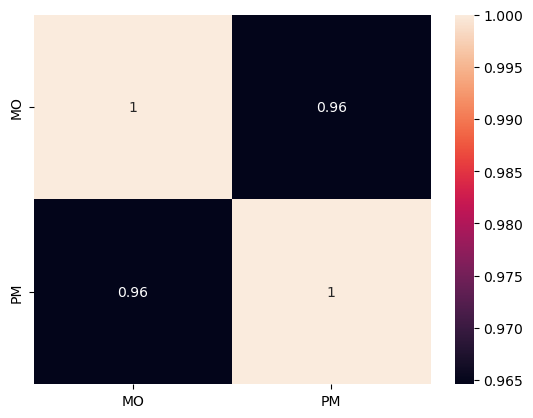

In [13]:
sn.heatmap(corr_matrix, annot = True)

## Automatically Pick N Pairs with high correlation

In [14]:
# Number of pairs you want to get
N = 20

In [15]:
listStockPairs = [("","", 0, "") for i in range(N)]
for i in range(numIndustries):
    symbols = stocksByIndustry[i]["symbol"].to_list()
    numStocksInIndustry = len(symbols)
    df = get_historical_as_df(symbols)
    corr_matrix = df.corr()
    for j in range(numStocksInIndustry):
        for k in range(j):

            if corr_matrix.iloc[j,k]> listStockPairs[-1][2]:
                listStockPairs[-1] = (corr_matrix.columns[j],corr_matrix.columns[k], corr_matrix.iloc[j,k], stocksByIndustry[i]["industry"].iloc[0])
                listStockPairs.sort(key=lambda x: -x[2])
        


In [16]:
listStockPairs

[('GOOG',
  'GOOGL',
  np.float64(0.9999064770530861),
  'Internet Content & Information'),
 ('FOX', 'FOXA', np.float64(0.9989491250697718), 'Entertainment'),
 ('SPGI',
  'MCO',
  np.float64(0.9922198746512344),
  'Financial Data & Stock Exchanges'),
 ('WMB', 'KMI', np.float64(0.9868972648396204), 'Oil & Gas Midstream'),
 ('NI', 'ATO', np.float64(0.9866488897176348), 'Utilities - Regulated Gas'),
 ('PNC', 'FITB', np.float64(0.9862318998384667), 'Banks - Regional'),
 ('PPL',
  'CMS',
  np.float64(0.98618181484725),
  'Utilities - Regulated Electric'),
 ('PNR',
  'PH',
  np.float64(0.9843797936721884),
  'Specialty Industrial Machinery'),
 ('PAYX', 'ADP', np.float64(0.9831287962798011), 'Software - Application'),
 ('NWS', 'NWSA', np.float64(0.9827801315281401), 'Entertainment'),
 ('WEC',
  'AEE',
  np.float64(0.982722165597269),
  'Utilities - Regulated Electric'),
 ('DTE',
  'CMS',
  np.float64(0.9820514647830009),
  'Utilities - Regulated Electric'),
 ('WFC', 'JPM', np.float64(0.981998

## Do some time series analysis on the increments of selected stocks

For each of these time series pairs, we now need to compute the increments and see, if we need to adjust the timeserieses to make the increment ts stationary. For this, we scale the respective stocks up such that the mean square of the time series gets minimized, i.e. we want to minimize

$\argmin \limits _{a >0} \mathbb E [~  ( S_1 - a \cdot S_2)^2 ~ ] $
 
where $S_1, S_2$ are the time serieses of the stocks. 
Note that this is just simple linear regression without intercept.
Thus we get the optimal value for $a$ from

$a = { \mathbb E [S_1 \cdot S_2 ] \over E[S_1^2]}$

In [3]:
symb1 = 'DTE'
symb2 = 'CMS'
ticker1 = yf.Ticker(symb1)
ticker2 = yf.Ticker(symb2)
start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 1, 1) #.now().date()#
x = ticker1.history(start=start_date, end=end_date)["Close"]#.to_numpy()
x_np = x.to_numpy()
y = ticker2.history(start=start_date, end=end_date)["Close"]#.to_numpy()
y_np = y.to_numpy()
scalingFactor = np.round(np.mean(x.to_numpy() *y.to_numpy()) / np.mean(x.to_numpy()*x.to_numpy()), decimals= 3) # we round this to 3 decimal to compute portions in which we buy stocks
a_x = 1000*scalingFactor
a_y = 1000
scalingFactor

np.float64(0.538)

In [4]:
a_x

np.float64(538.0)

In [5]:
a_y

1000

Text(0.5, 1.0, 'Stocks (scaled)')

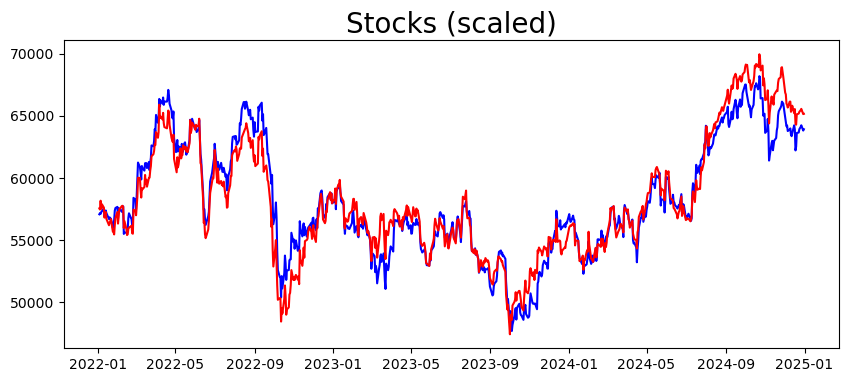

In [6]:
plt.figure(figsize=(10,4))
plt.plot(a_x*x, 'b')
plt.plot(a_y*y, 'r')
plt.title('Stocks (scaled)', fontsize=20)

Text(0.5, 1.0, 'Stocks (not scaled)')

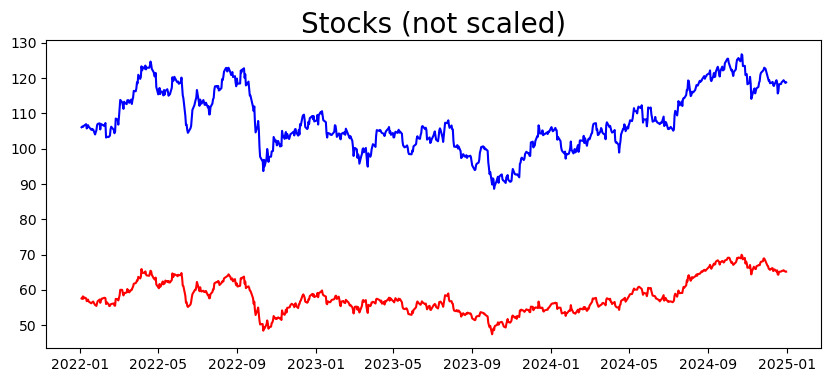

In [7]:
plt.figure(figsize=(10,4))
plt.plot(x, 'b')
plt.plot(y, 'r')
plt.title('Stocks (not scaled)', fontsize=20)

In [8]:
increments = a_x*x - a_y*y
increments_np = increments.to_numpy()

Text(0.5, 1.0, 'Increments (of scaled scaled stocks)')

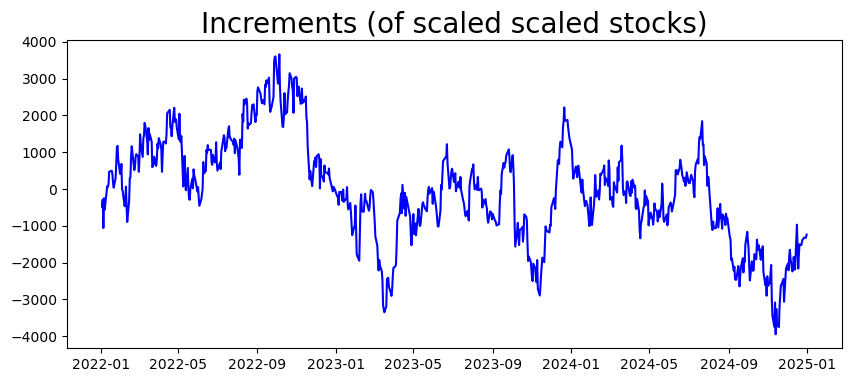

In [9]:
plt.figure(figsize=(10,4))
plt.plot(increments, 'b')
plt.title('Increments (of scaled scaled stocks)', fontsize=20)

In [58]:
thresholdSell = np.percentile(np.abs(increments_np), 30)

In [59]:
thresholdBuy = np.percentile(np.abs(increments_np), 95)

Text(0.5, 1.0, 'Increments (absolute difference)')

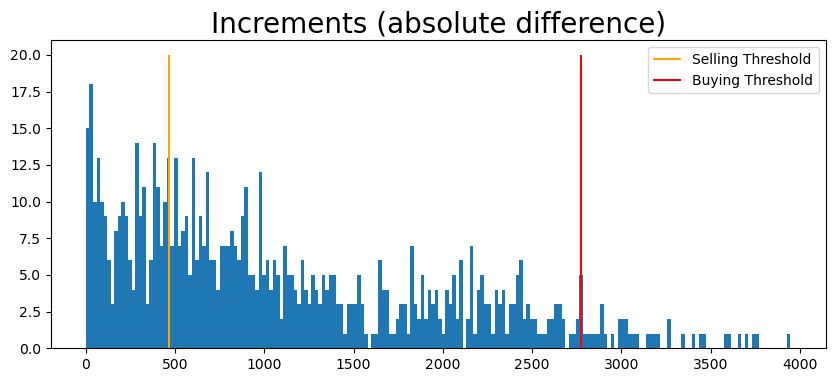

In [60]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(increments_np), bins=200)
plt.vlines(thresholdSell, ymax= 20, ymin=0, label="Selling Threshold", colors="orange")
plt.vlines(thresholdBuy, ymax= 20, ymin=0, label="Buying Threshold", colors="r")
plt.legend()
plt.title('Increments (absolute difference)', fontsize=20)

In [68]:
adfuller(increments_np)

(np.float64(-2.934873086137499),
 np.float64(0.04144043021626377),
 2,
 750,
 {'1%': np.float64(-3.439099096730074),
  '5%': np.float64(-2.8654013553540745),
  '10%': np.float64(-2.568826193777778)},
 np.float64(10645.632739548626))

ADF test gives us a p value of 0.04, which is significant to us. Thus we can assume that our increments are stationary. So let's build our pairs trading strategy. Note that we only testet the time series up until 1/1/2025. Now we would like to see how mean reversion performs up until today

In [69]:
class PairsTradingStrategy(Strategy):
    def __init__(self, numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade, thresholdBuy, thresholdSell):
        self.numShares1_ToBuy_perTrade = numShares1_ToBuy_perTrade
        self.numShares2_ToBuy_perTrade = numShares2_ToBuy_perTrade
        self.thresholdBuy =thresholdBuy
        self.thresholdSell = thresholdSell

    def updatePortfolio(self, oldPortfolio, cash, pricesAssets, assets):
        increments = self.numShares1_ToBuy_perTrade* pricesAssets[0] - self.numShares2_ToBuy_perTrade* pricesAssets[1]
        abs_increments = np.abs(increments)
        if abs_increments > self.thresholdBuy:
            cashMinusDebt = cash - np.minimum(oldPortfolio[0], 0)*pricesAssets[0] - np.minimum(oldPortfolio[1], 0)*pricesAssets[1]
            factorBuy = cashMinusDebt // (pricesAssets[0] *self.numShares1_ToBuy_perTrade  + pricesAssets[1]*self.numShares2_ToBuy_perTrade)
            if factorBuy >= 1:
                if increments > 0 : 
                    return [-factorBuy*self.numShares1_ToBuy_perTrade, factorBuy*self.numShares2_ToBuy_perTrade]
                else:
                    return [factorBuy*self.numShares1_ToBuy_perTrade, -factorBuy*self.numShares2_ToBuy_perTrade]
            return [0,0]
        elif abs_increments < self.thresholdSell:
            return [0,0]
        
        else:
            return oldPortfolio

In [ ]:
numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade = 538.0, 1000
myStrat = PairsTradingStrategy(numShares1_ToBuy_perTrade, numShares2_ToBuy_perTrade, thresholdBuy, thresholdSell)

testStart = datetime(2025,1,1)
testEnd = datetime.now().date()
df1 = yf.download(symb1, start = testStart , end = testEnd)
df2 = yf.download(symb2, start = testStart, end = testEnd)
df1.columns = df1.columns.get_level_values('Price')
df2.columns = df2.columns.get_level_values('Price')
bt = Backtester([df1,df2], myStrat, 
                capital=1000000)

bt.run()


C:\Users\seand\AppData\Local\Temp\ipykernel_10040\1571023024.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df1 = yf.download(symb1, start = testStart , end = testEnd)
[*********************100%***********************]  1 of 1 completed
C:\Users\seand\AppData\Local\Temp\ipykernel_10040\1571023024.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df2 = yf.download(symb2, start = testStart, end = testEnd)
[*********************100%***********************]  1 of 1 completed


In [84]:
bt.reportResults()

  Start Capital    Final Capital    Absolute Gains  Relative Gains      Volatility (via log returns)    Number Of Dates With Trades    Number Trading Days
---------------  ---------------  ----------------  ----------------  ------------------------------  -----------------------------  ---------------------
        1000000      1.02284e+06             22841  2.28%                                  0.0386603                              7                    160


In [85]:
bt.plot()

# Industry Trading
We want to try a strategy next, which is basically a mean reversion for a stock, which deviates from its industry mean, i.e. when a stock goes below the industry mean: buy and sell if it approaches the mean again.